In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd


import torch.optim as optim
#from torch.utils.tensorboard import SummaryWriter

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, Theta
from darts.metrics import mape, rmse, r2_score
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.datasets import SunspotsDataset, AirPassengersDataset

import sys
import time
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


FC_N = 36               # forecast periods
FC_STRIDE = 10
FC_START = "19590101"   # period at which to split training and validation dataste

In [4]:
EPOCH = 3       # for testing or debugging, rather than real forecasts, 
                  # set EPOCH to a low value like 3; for the real deal: 300 
                  # 300 will take as much as 30 - 50 minutes of processing time

In [7]:
ts = pd.read_csv('clean-data/rice_quality_indo_2013-2019.csv', index_col = 0)
ts.describe()

,premium,medium,bad
count,84.000000,84.000000,84.000000
mean,9089.954286,8817.669048,8525.161548
std,756.150463,727.361360,732.405036
min,7420.720000,7261.710000,6832.740000
25%,8380.012500,8128.350000,8036.215000
50%,9419.880000,8968.995000,8614.865000
75%,9571.840000,9303.305000,9041.580000
max,10381.740000,10215.160000,9987.100000


In [14]:
## load data
ts = AirPassengersDataset().load()

series = ts  
df = ts.pd_dataframe()
df

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [16]:
df.describe()

component,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


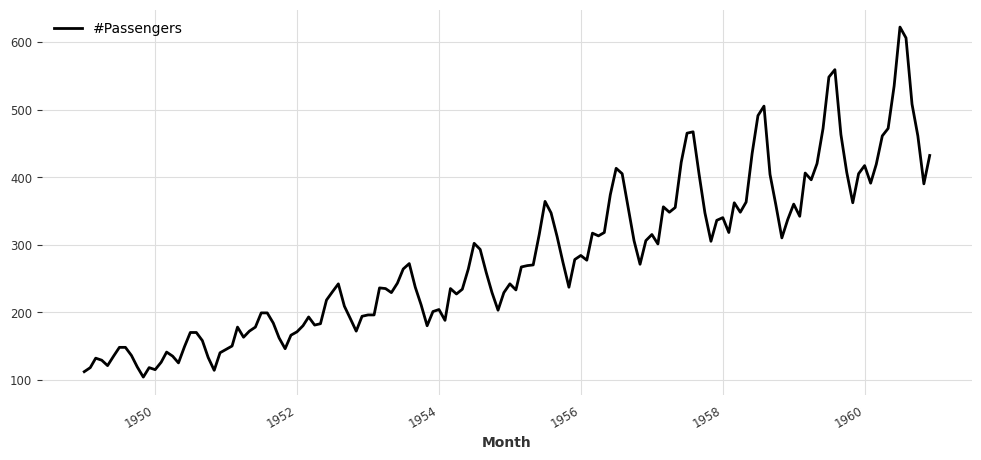

In [17]:
# plot the observation
plt.figure(100, figsize=(12,5))
series.plot()

In [18]:
# analyze its seasonality

is_seasonal, periodicity = check_seasonality(ts, max_lag=240)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 12.0
periodicity (~years) : 1.0


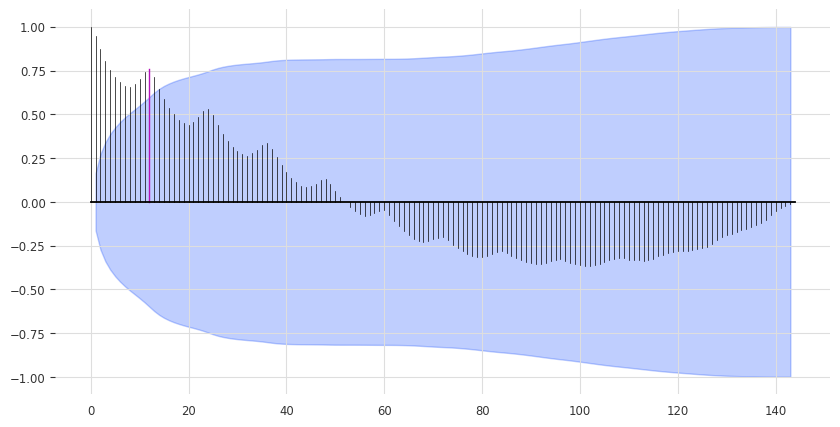

In [25]:
# plot its autocorelation function
plot_acf(ts, periodicity, max_lag=len(ts)-1)

In [26]:
# split training vs test dataset
train, val = ts.split_after(pd.Timestamp(FC_START))

In [27]:
# normalize the time series

trf = Scaler()
# fit the transformer to the training dataset
train_trf = trf.fit_transform(train)
# apply the transformer to the validation set and the complete series 
val_trf = trf.transform(val)
ts_trf = trf.transform(ts)

In [28]:
# create month and year covariate series

year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), 
        freq=ts.freq_str, 
        periods=1000),
    attribute='year', 
    one_hot=False)
year_series = Scaler().fit_transform(year_series)

month_series = datetime_attribute_timeseries(
    year_series, 
    attribute='month', 
    one_hot=True)

covariates = year_series.stack(month_series)
cov_train, cov_val = covariates.split_after(pd.Timestamp(FC_START))

In [37]:
# set up, fit, run, plot, and evaluate the RNN model

def run_RNN(flavor, ts, train, val):

    # set the model up
    model_RNN = RNNModel(
        model=flavor,
        model_name=flavor + str(" RNN"),
        input_chunk_length=periodicity,
        training_length=20,
        hidden_dim=20,
        batch_size=16,
        n_epochs=EPOCH,
        dropout=0,
        optimizer_kwargs={'lr': 1e-3},
        log_tensorboard=True,
        random_state=42,
        force_reset=True)
        
    if flavor == "RNN": flavor = "Vanilla" 

    # fit the model
    fit_it(model_RNN, train, val, flavor)

    # compute N predictions
    pred = model_RNN.predict(n=FC_N, future_covariates=covariates) 

    # plot predictions vs actual
    plot_fitted(pred, ts, flavor)

    # print accuracy metrics
    res_acc = accuracy_metrics(pred, ts)    
    print(flavor + " : ")
    _ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]

    return [pred, res_acc]

# helper function: fit the RNN model

def fit_it(model, train, val, flavor):
    t_start =  time.perf_counter()
    print("\nbeginning the training of the {0} RNN:".format(flavor))

    res = model.fit(train,
             future_covariates=covariates,
             val_series=val,
             val_future_covariates=covariates,
             verbose=True)

    res_time = time.perf_counter() - t_start
    print("training of the {0} RNN has completed:".format(flavor), f'{res_time:.2f} sec')

    return res

# helper function: plot the predictions

def plot_fitted(pred, act, flavor):
    plt.figure(figsize=(12,5))
    act.plot(label='actual')
    pred.plot(label='prediction')
    plt.title("RNN: {0} flavor".format(flavor) + ' | MAPE: {:.2f}%'.format(mape(pred, act)))
    plt.legend();

# helper function: compute accuracy metrics
   
def accuracy_metrics(pred, act):
    act2 = act.slice_intersect(pred)
    pred2 = pred.slice_intersect(act2)
    resid = pred2 - act2
    sr = resid.pd_series()
    sa = act2.pd_series()
    sp = pred2.pd_series()
    res_mape = mape(pred2, act2)
    res_r2 = r2_score(pred2, act2)
    res_rmse = rmse(pred2, act2)
    res_pe = sr / sa
    n_act = len(act2)
    res_rmspe = np.sqrt(np.sum(res_pe**2) / n_act)    # root mean square percentage error
    res_std = np.std(sr)                               # std error of the model = std deviation of the noise
    res_se = res_std / np.sqrt(n_act)                  # std error in estimating the mean
    res_sefc = np.sqrt(res_std + res_se**2)            # std error of the forecast
    
    res_accuracy = {
        "MAPE":res_mape,"RMSPE":res_rmspe, "RMSE":res_rmse, 
        "-R squared":-res_r2, "se": res_sefc}
    return res_accuracy

In [41]:
# run 3 different flavors of RNN on the time series:
flavors = ["LSTM", "GRU", "RNN"]

# call the RNN model setup for each of the 3 RNN flavors
res_flavors = [run_RNN(flv, ts_trf, train_trf, val_trf) for flv in flavors]


beginning the training of the LSTM RNN:
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.98it/s]
LSTM : 
MAPE : 11.1831
RMSPE : 0.1071
RMSE : 0.0996
-R squared : -0.6051
se : 0.2125

beginning the training of the GRU RNN:
Epoch 127:  12%|█▎        | 1/8 [00:00<00:00, 62.12it/s, loss=0.000697, v_num=logs, train_loss=0.000772, val_loss=0.00435]

Theta forecast has completed:  3.00 sec
MAPE : 3.1119
RMSPE : 0.0448
RMSE : 20.4686
-R squared : -0.8987
se : 6.2176


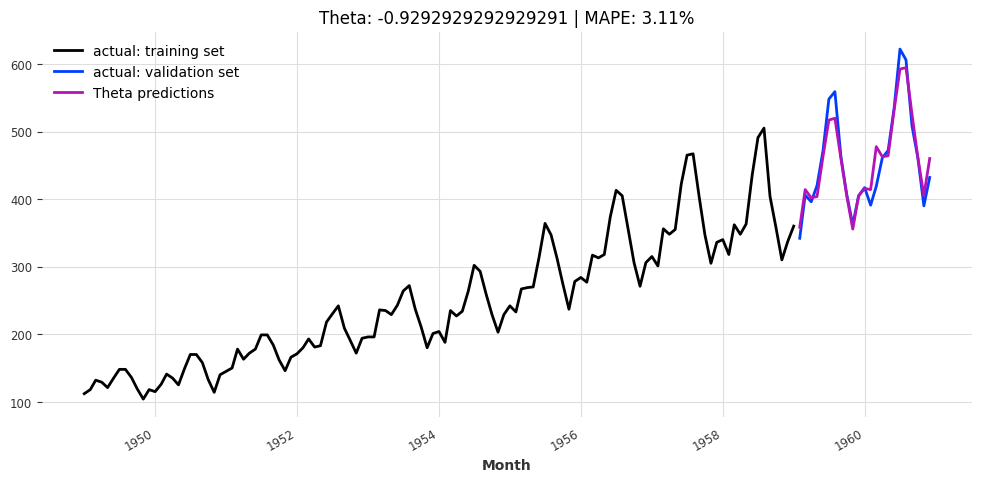

In [39]:
# Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
t_start =  time.perf_counter()
# search for best theta among 100 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)
    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta


# fit the model
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred = best_theta_model.predict(len(val))

# review the Theta results
plt.figure(figsize=(12,5))
train.plot(label='actual: training set')
val.plot(label='actual: validation set')
pred.plot(label='Theta predictions')
plt.title("Theta: {0}".format(best_theta) + ' | MAPE: {:.2f}%'.format(mape(pred, val)))
plt.legend();

res_time = time.perf_counter() - t_start
res_acc = accuracy_metrics(pred, val)
print("Theta forecast has completed: ", f'{res_time:.2f} sec')
_ = [print(k,":",f'{v:.4f}') for k,v in res_acc.items()]
results = [pred, res_acc]

In [40]:
# collect the forecasters's accuracy metrics in a dataframe

dict_models = {"LSTM":res_flavors[0][1], "GRU":res_flavors[1][1],
    "Vanilla":res_flavors[2][1], "Theta":res_acc}
df_acc = pd.DataFrame.from_dict(dict_models, orient="index").T
pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,LSTM,GRU,Vanilla,Theta
MAPE,5.031625,4.811109,3.394095,3.111937
RMSPE,0.052943,0.051441,0.040064,0.044793
RMSE,0.047609,0.048651,0.041005,20.468560
-R squared,-0.927116,-0.918127,-0.935391,-0.898710
se,0.169070,0.178939,0.185979,6.217629
